In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [4]:
print(tf.__version__, tfp.__version__)

2.0.0-beta1 0.7.0-dev20190510


In [5]:
TRAIN_SIZE=482608
BATCH_SIZE=512
TEST_SIZE=10000
DIMS = (32, 24, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [6]:
DATASET_ID = 'canary_segmented'

In [7]:
record_loc = DATA_DIR / 'tfrecords' / "canary_32x24.tfrecord"

In [8]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [9]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "phrase": tf.int64,
    "indv": tf.string,
}

In [10]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [11]:
spec, index, phrase, indv  = next(iter(dataset))

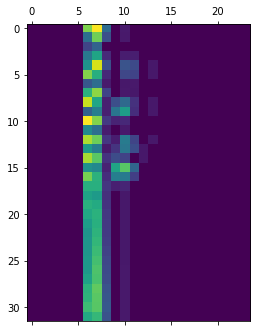

In [12]:
plt.matshow(spec.numpy().reshape(DIMS[:2]))

In [13]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [14]:
N_Z = 2
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 3 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 3, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]

def vaegan_discrim():
    inputs = tf.keras.layers.Input(shape=DIMS)
    conv1 = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation="relu"
            )(inputs)
    conv2 = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation="relu"
            )(conv1)
    conv3 = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    )(conv2)
    flatten = tf.keras.layers.Flatten()(conv3)
    lastlayer = tf.keras.layers.Dense(units=512, activation="relu")(flatten)
    outputs = tf.keras.layers.Dense(units=1, activation = None)(lastlayer)
    return inputs, lastlayer, outputs

In [15]:
from avgn.tensorflow.VAEGAN import VAEGAN, plot_reconstruction, plot_losses

In [16]:
# the unet function 
gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    
# model
model = VAEGAN(
    enc = encoder,
    dec = decoder,
    vae_disc_function = vaegan_discrim,
    lr_base_gen = 1e-3, # 
    lr_base_disc = 1e-4, # the discriminator's job is easier than the generators so make the learning rate lower
    latent_loss_div=1, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
    sig_mult = 10, # how binary the discriminator's learning rate is shifted (we squash it with a sigmoid)
    recon_loss_div = .001, # this variable will depend on your dataset - choose a number that will bring your latent loss to ~1-10
)

In [17]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [18]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns=[
    'd_prop',
    'latent_loss',
    'discrim_layer_recon_loss',
    'gen_fake_loss',
    'disc_fake_loss',
    'disc_real_loss',
])

In [19]:
n_epochs = 500
epoch = 0

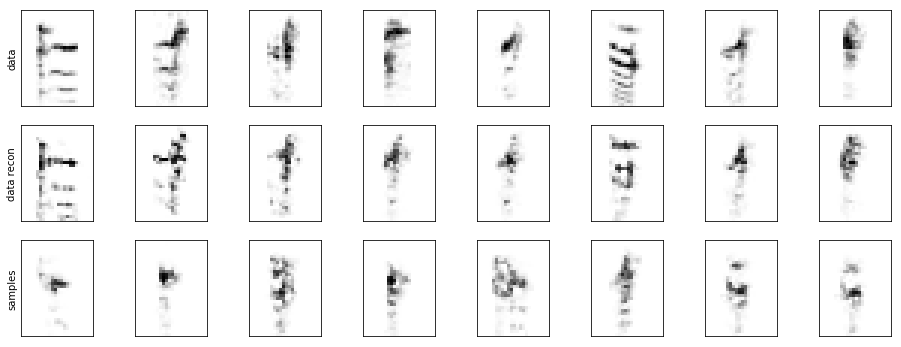

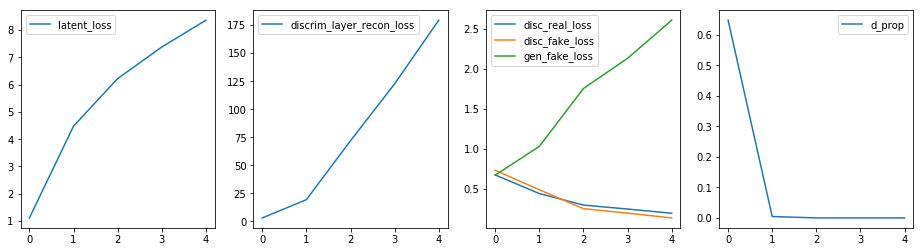

KeyboardInterrupt: 

In [21]:
for epoch in range(epoch, n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        x = tf.cast(tf.reshape(train_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        model.train_net(x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        loss.append(model.compute_loss(x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()

    plot_reconstruction(model, example_data, BATCH_SIZE, N_Z=N_Z)
    
    plot_losses(losses)

### Plot samples from latent

In [22]:
z = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)[0].numpy()

In [23]:
np.shape(z)

(512, 2)

In [24]:
xmax, ymax = np.max(z, axis=0)
xmin, ymin = np.min(z, axis=0)
print(xmax, ymax, xmin, ymin)

9.502764 6.800223 -10.66144 -10.654737


(-0.5, 479.5, -0.5, 639.5)

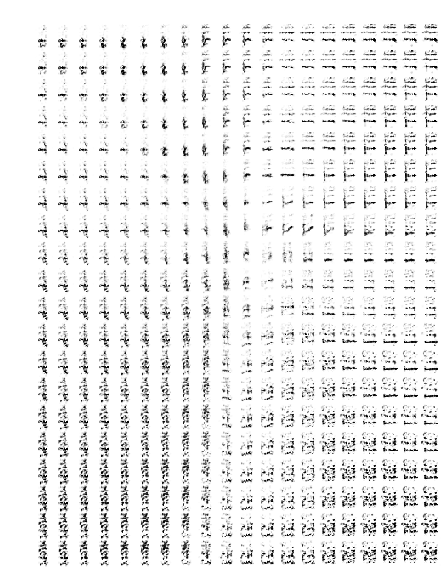

In [27]:
# sample from grid
nx = ny= 20
meshgrid = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, DIMS[0], DIMS[1], DIMS[2])
# fill canvas
canvas = np.zeros((nx*DIMS[0], ny*DIMS[1]))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*DIMS[0]:xi*DIMS[0]+DIMS[0], yi*DIMS[1]:yi*DIMS[1]+DIMS[1]] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(canvas, vmin = 0, cmap=plt.cm.Greys, origin = 'lower')
ax.axis('off')

###  plot dataset 

In [28]:
all_x = []
all_z = []
all_indv = []
all_labels = []
for bi, (batch, train_x) in tqdm(
    enumerate(zip(range(N_TRAIN_BATCHES), train_dataset)), total=N_TRAIN_BATCHES
):
    x = train_x[0]
    all_x.append(x)
    x = tf.cast(tf.reshape(x, [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
    #model.train_net(x)
    z = tf.split(model.enc(x), num_or_size_splits=2, axis=1)[0].numpy()
    #z = model.encode(example_data).sample().numpy()
    all_z.append(z)
    all_indv.append(train_x[3].numpy())
    all_labels.append(train_x[2].numpy())
    if bi > 100: break
all_z = np.vstack(all_z)
all_indv = np.concatenate(all_indv)
all_labels = np.concatenate(all_labels)
all_x = np.concatenate(all_x)
all_x = np.reshape(all_x, [len(all_x)] + list(DIMS[:2]))

In [29]:
from avgn.visualization.projections import scatter_spec

In [30]:
np.shape(all_z)

(52224, 2)

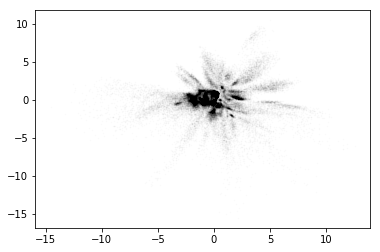

In [31]:
plt.scatter(all_z[:,0], all_z[:,1], s=1, c='k', alpha=0.01)

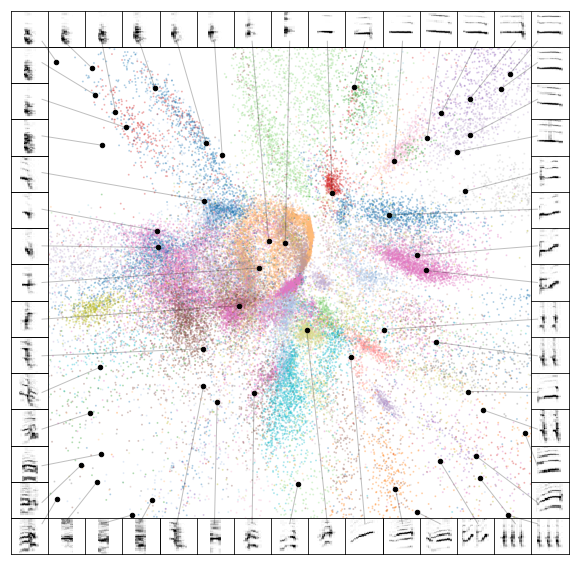

In [32]:
scatter_spec(
        np.vstack(all_z),
        all_x,
        column_size=15,
        x_range = [-4,4],
        y_range = [-4,4],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(all_labels),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
);